## PROJECT-3. Анализ воронки 

### Цель
#### Исследовать поведение пользователей в обновлённом приложении.

### Гипотеза 1
#### По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
### Гипотеза 2
#### Кажется, повторное прохождение обучения положительно влияет на оплату, верно?
### Гипотеза 3
#### Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

### Задачи

#### 1. Определить, насколько обучение сокращает время прохождения этапов игры.
#### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
#### 3. Определить, насколько прозрачен процесс взаимодействия с игрой.

## Обработка и подготовка данных

Импортируем библиотеки:

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Читаем данные из файлов:

In [321]:

events_dataf = pd.read_csv('data/7_4_Events.csv') 
events_df = events_dataf.copy()

Преобразуем дату к стандарту datetime, с учетом возникшей ошибки:

In [322]:
events_df['start_time'] =  pd.to_datetime(events_df['start_time'], format='%Y-%m-%dT%H:%M:%S', dayfirst=True, errors='coerce')

Найдем всех пользователей, которые зарегистрировались в 2018 году

In [323]:
mask1 = events_df['event_type'] == 'registration'
mask2 = events_df['start_time'] >= '2018-01-01'
mask3 = events_df['start_time'] < '2019-01-01'
user_registration_in_2018 = events_df[mask1 & mask2 & mask3]['user_id'].to_list()

Выведем events_df по пользователям, зарегистрировавшимся в 2018 году:

In [324]:
events_df = events_df[events_df['user_id'].isin(user_registration_in_2018)]

Прочитаем данные из 2-го файла с оплатами:

In [325]:
purchase_dataf = pd.read_csv('data/purchase.csv') 
purchase_df = purchase_dataf.copy()

Выведем purchase_df по пользователям, зарегистрировавшимся в 2018 году:

In [326]:
purchase_df = purchase_df[purchase_df['user_id'].isin(user_registration_in_2018)]

Преобразуем дату к формату datetime:

In [327]:
purchase_df['event_datetime'] =  pd.to_datetime(purchase_df['event_datetime'])

Добавим в таблицу с покупками столбец "event_type", равный "purchase":

In [328]:
purchase_df['event_type'] = 'purchase'

Переименуем столбцы с одинакомыми названиями

In [329]:
events_df = events_df.rename(columns={'id': 'event_id'})
purchase_df = purchase_df.rename(columns={'id': 'purchase_id'})

Также переименуем столбец start_time, чтобы время покупок и остальных событий были в одном столбце

In [330]:
events_df = events_df.rename(columns={'start_time': 'event_datetime'})

Объединим эти две таблицы:

In [331]:
event_purchase_df = pd.concat(
    [events_df,purchase_df],
    ignore_index=True)
display(event_purchase_df)

,event_id,event_type,selected_level,event_datetime,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [332]:
event_purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   event_datetime  68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.2+ MB


## Проверка гипотезы 1
#### Для этого нам необходимо cравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

Найдем пользователей, которые завершили обучение:

In [333]:
user_tutorial_finish = event_purchase_df[event_purchase_df['event_type'] == 'tutorial_finish']['user_id'].to_list()

Найдем пользователей, не начинавших обучение:

In [334]:
user_tutorial_start = event_purchase_df[
    event_purchase_df['event_type'] == 'tutorial_start']['user_id'].unique()

Добавим группировочный столбец, где укажем, кто прошел обучение, кто не начинал учиться, а также кто не окончил:

In [335]:
def education(x):
    if x in user_tutorial_finish:
        return 'finish'
    elif x in user_tutorial_start:
        return 'no finish'
    else:
        return 'no start'
        
event_purchase_df['education'] = event_purchase_df['user_id'].apply(education)
event_purchase_df.head()

,event_id,event_type,selected_level,event_datetime,tutorial_id,user_id,purchase_id,amount,education
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,no start
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finish
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finish
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finish
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finish


Создадим сводную таблицу с указанием времени по разным этапам:

In [336]:
user_event_purchase = event_purchase_df.pivot_table(
    values = 'event_datetime',
    index = ['user_id', 'education'],
    columns = 'event_type',
    aggfunc= 'min'
).reset_index()
user_event_purchase.head()

event_type,user_id,education,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,no start,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,finish,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,finish,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,finish,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,finish,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


Теперь посчитаем время прохождения различных этапов, т.к. не все этапы являются обязательными, то время каждого этапа будем считать от начального обязательного этапа (регистрации):

In [337]:
events = ['tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase']
for event in events:
    user_event_purchase['{}_delta'.format(event)] = user_event_purchase[event] - user_event_purchase['registration']

user_event_purchase.head() 

event_type,user_id,education,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,tutorial_start_delta,tutorial_finish_delta,level_choice_delta,pack_choice_delta,purchase_delta
0,27832,no start,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,27833,finish,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,0 days 13:40:15,0 days 13:42:43,NaT,NaT,NaT
2,27834,finish,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,0 days 11:11:01,0 days 11:12:51,NaT,NaT,NaT
3,27835,finish,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 03:06:04,0 days 03:11:28,0 days 08:42:35,0 days 08:43:56,NaT
4,27836,finish,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,0 days 01:26:33,0 days 02:14:51,NaT,NaT,NaT


Удалим лишние столбцы:

In [340]:
user_event_purchase_education = user_event_purchase.copy()
user_event_purchase_education = user_event_purchase_education.drop(
    ['registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase', 'user_id'], axis=1)
user_event_purchase_education.head()

event_type,education,tutorial_start_delta,tutorial_finish_delta,level_choice_delta,pack_choice_delta,purchase_delta
0,no start,NaT,NaT,NaT,NaT,NaT
1,finish,0 days 13:40:15,0 days 13:42:43,NaT,NaT,NaT
2,finish,0 days 11:11:01,0 days 11:12:51,NaT,NaT,NaT
3,finish,0 days 03:06:04,0 days 03:11:28,0 days 08:42:35,0 days 08:43:56,NaT
4,finish,0 days 01:26:33,0 days 02:14:51,NaT,NaT,NaT


Создадим сводную таблицу по видам прохождения обучения:

In [341]:
user_event_purchase_education = user_event_purchase_education.groupby(['education']).mean().round(2)
display(user_event_purchase_education)

event_type,tutorial_start_delta,tutorial_finish_delta,level_choice_delta,pack_choice_delta,purchase_delta
education,,,,,
finish,0 days 04:31:04.938146341,0 days 04:43:18.761268292,0 days 07:05:36.854819357,0 days 07:10:35.660162287,4 days 00:30:03.247408431
no finish,0 days 05:25:02.892412935,NaT,0 days 08:12:57.551816958,0 days 08:22:32.392197125,4 days 05:32:53.213740458
no start,NaT,NaT,0 days 05:15:33.122448979,0 days 05:07:16.175675675,4 days 09:06:01.909090909


Преобразуем тип данных в сводной таблице из временного в числовой. За единицу измерения интервалов выберем час.

In [342]:
user_event_purchase_education = round(user_event_purchase_education/pd.Timedelta('1 hour'), 2)
user_event_purchase_education = user_event_purchase_education.fillna(0)
user_event_purchase_education['education'] = user_event_purchase_education.index
user_event_purchase_education

event_type,tutorial_start_delta,tutorial_finish_delta,level_choice_delta,pack_choice_delta,purchase_delta,education
education,,,,,,
finish,4.52,4.72,7.09,7.18,96.50,finish
no finish,5.42,0.00,8.22,8.38,101.55,no finish
no start,0.00,0.00,5.26,5.12,105.10,no start


Отфильтруем пользователей, которые начали учиться, но не закончили:

In [343]:
mask = user_event_purchase_education['education'] != 'no finish'
user_event_purchase_education = user_event_purchase_education[mask]
user_event_purchase_education

event_type,tutorial_start_delta,tutorial_finish_delta,level_choice_delta,pack_choice_delta,purchase_delta,education
education,,,,,,
finish,4.52,4.72,7.09,7.18,96.5,finish
no start,0.00,0.00,5.26,5.12,105.1,no start


Теперь перейдем к построению диаграмм:

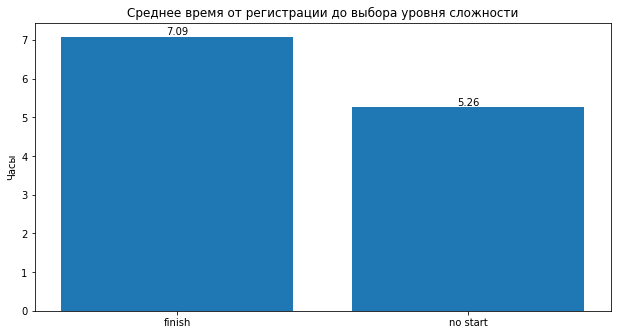

In [344]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
spl = ax.bar( x = user_event_purchase_education['education'], height =user_event_purchase_education['level_choice_delta'])

ax.set_title('Среднее время от регистрации до выбора уровня сложности')
ax.set_ylabel('Часы')

for index,data in enumerate(user_event_purchase_education['level_choice_delta']):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=10), ha="center", va="bottom")

plt.show()

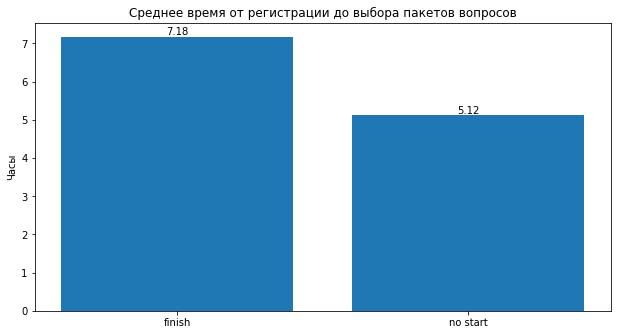

In [345]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
spl = ax.bar( x = user_event_purchase_education['education'], height =user_event_purchase_education['pack_choice_delta'])

ax.set_title('Среднее время от регистрации до выбора пакетов вопросов')
ax.set_ylabel('Часы')

for index,data in enumerate(user_event_purchase_education['pack_choice_delta']):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=10), ha="center", va="bottom")

plt.show()

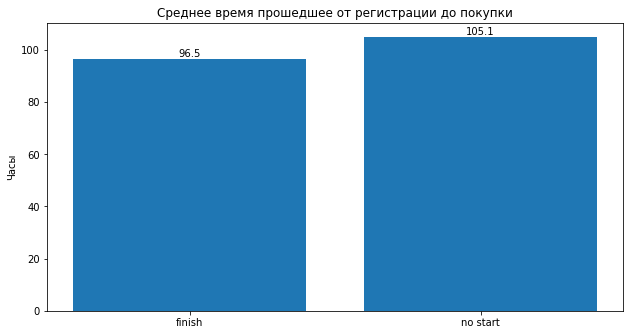

In [346]:

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
spl = ax.bar( x = user_event_purchase_education['education'], height =user_event_purchase_education['purchase_delta'])

ax.set_title('Среднее время прошедшее от регистрации до покупки')
ax.set_ylabel('Часы')

for index,data in enumerate(user_event_purchase_education['purchase_delta']):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=10), ha="center", va="bottom")

plt.show()

### Вывод по 1-й гипотезе: 
У пользователей, не проходивших обучение, среднее время от регистрации до выбора уровня сложности и пакетов вопросов меньше, чем у пользователей, проходивших обучение. Это, видимо, связано с тем, что пользователи потратили время на прохождение обучения. Но среднее время от регистрации до покупки у обученных пользователей (96,5 часов) меньше, чем у не обученных (105,1 часов). Разница составляет 8,6 часов. 


## Переходим к проверке 2-й гипотезы:
#### Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

Создадим сводную таблицу по количеству этапов у пользователей:

In [347]:
user_pivot = event_purchase_df.pivot_table(
    values = 'event_datetime',
    index = 'user_id',
    columns = 'event_type',
    aggfunc= 'count'
).reset_index()
user_pivot = user_pivot.fillna(0)
user_pivot.head()

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,0.0,0.0,0.0,1.0,0.0,0.0
1,27833,0.0,0.0,0.0,1.0,1.0,1.0
2,27834,0.0,0.0,0.0,1.0,1.0,1.0
3,27835,1.0,1.0,0.0,1.0,1.0,1.0
4,27836,0.0,0.0,0.0,1.0,1.0,2.0


Создадим сводную таблицу по количеству обучений, которые были начаты:

In [348]:
user_pivot_start = user_pivot.groupby('tutorial_start').agg({'user_id':['count'],'purchase':['sum']}).reset_index()
user_pivot_start['percent'] = (user_pivot_start['purchase']['sum'] * 100/user_pivot_start['user_id']['count']).round(2)
display(user_pivot_start)

event_type,tutorial_start,user_id,purchase,percent
,,count,sum,
0,0.0,8068,22.0,0.27
1,1.0,9103,1207.0,13.26
2,2.0,1589,218.0,13.72
3,3.0,427,51.0,11.94
4,4.0,221,30.0,13.57
5,5.0,109,16.0,14.68
6,6.0,116,14.0,12.07
7,7.0,94,12.0,12.77
8,8.0,86,13.0,15.12


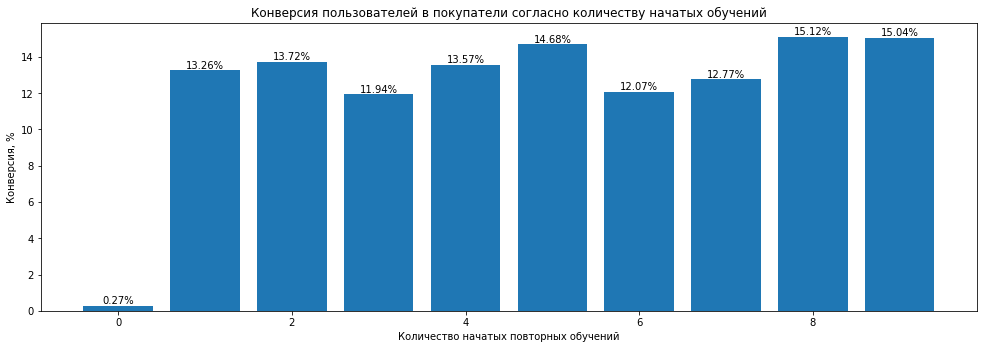

In [349]:
fig = plt.figure(figsize=(13, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = user_pivot_start['tutorial_start'], height = user_pivot_start['percent'])
axes.set_xlabel('Количество начатых повторных обучений')
axes.set_ylabel('Конверсия, %')
axes.set_xticks = user_pivot_start['percent']
axes.set_title('Конверсия пользователей в покупатели согласно количеству начатых обучений')

for index,data in enumerate(user_pivot_start['percent']):
    plt.text(x=index , y=data , s=f"{data}%" , fontdict=dict(fontsize=10), ha="center", va="bottom")

plt.show()

event_type,tutorial_finish,user_id,purchase,percent
,,count,sum,
0,0.0,9676,153.0,1.58
1,1.0,8015,1143.0,14.26
2,2.0,1321,182.0,13.78
3,3.0,345,44.0,12.75
4,4.0,178,19.0,10.67
5,5.0,117,19.0,16.24
6,6.0,101,15.0,14.85
7,7.0,97,15.0,15.46
8,8.0,54,6.0,11.11


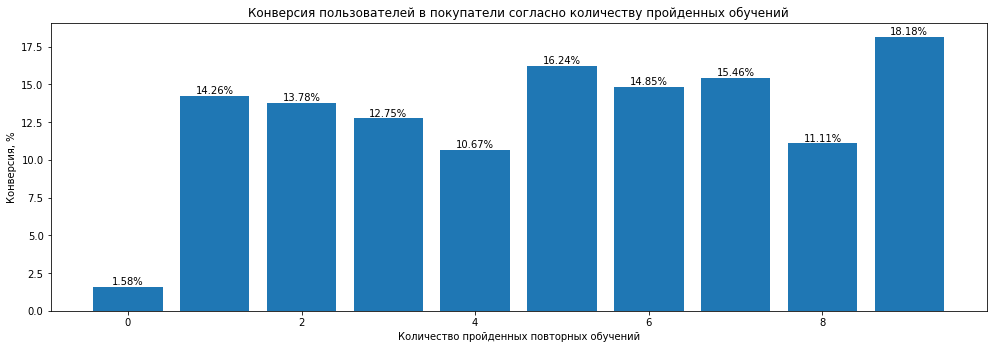

In [350]:
user_pivot_finish = user_pivot.groupby('tutorial_finish').agg({'user_id':['count'],'purchase':['sum']}).reset_index()
user_pivot_finish['percent'] = (user_pivot_finish['purchase']['sum'] * 100/user_pivot_finish['user_id']['count']).round(2)
display(user_pivot_finish)
fig = plt.figure(figsize=(13, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = user_pivot_finish['tutorial_finish'], height = user_pivot_finish['percent'])
axes.set_xlabel('Количество пройденных повторных обучений')
axes.set_ylabel('Конверсия, %')
axes.set_xticks = user_pivot_finish['percent']
axes.set_title('Конверсия пользователей в покупатели согласно количеству пройденных обучений')

for index,data in enumerate(user_pivot_finish['percent']):
    plt.text(x=index , y=data , s=f"{data}%" , fontdict=dict(fontsize=10), ha="center", va="bottom")

plt.show()

## Вывод по 2-й гипотезе:
#### Из диаграмм видно, что конверсия пользователей, прошедших и начавших обучение колеблется примерно на одном уровне. Для начатых обучений конверсия находится в диапазоне от 12% до 15%, в то время как конверсия пользователей, не начинавших обучение, составляет 0,27%. Можно утверждать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

## Переходим к проверке 3-й гипотезы:
#### Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Создадим таблицу с датами выбора уровня сложности:

In [ ]:
events_df['data_level_choice'] = events_df[events_df['event_type'] =='level_choice']['event_datetime']
event_data_level = events_df.copy()
event_data_level = event_data_level.drop(['event_id', 'event_type', 'selected_level', 'event_datetime', 'tutorial_id'], axis=1)
event_data_level = event_data_level.dropna(subset='data_level_choice',axis=0)
event_data_level.head()

,user_id,data_level_choice
51424,27835,2018-01-01 20:37:22
51428,27839,2018-01-01 22:37:50
51441,27840,2018-01-02 05:18:42
51443,27845,2018-01-02 06:19:18
51450,27842,2018-01-02 08:46:03


Создадим таблицу с датами начала обучения:

In [ ]:
events_df['data_tutorial_start'] = events_df[events_df['event_type'] =='tutorial_start']['event_datetime']
event_data_tutorial_start = events_df.copy()
event_data_tutorial_start = event_data_tutorial_start.drop(['event_id', 'event_type', 'selected_level', 'event_datetime', 'tutorial_id', 'data_level_choice'], axis=1)
event_data_tutorial_start = event_data_tutorial_start.dropna(subset='data_tutorial_start',axis=0)
event_data_tutorial_start.head()

,user_id,data_tutorial_start
51412,27836,2018-01-01 14:54:40
51413,27835,2018-01-01 15:00:51
51415,27836,2018-01-01 15:40:43
51417,27833,2018-01-01 17:47:40
51420,27839,2018-01-01 19:11:36


Объединим наши таблицы:

In [354]:
event_data = event_data_level.merge(
    event_data_tutorial_start,
    on = 'user_id',
    how = 'left'
)
event_data.head()

,user_id,data_level_choice,data_tutorial_start
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07
3,27845,2018-01-02 06:19:18,2018-01-02 03:03:44
4,27845,2018-01-02 06:19:18,2018-01-02 07:08:00


Теперь создадим столбец, указывающий, какое событие произошло раньше:

In [355]:
event_data['timedelta'] = event_data['data_level_choice'] - event_data['data_tutorial_start']
event_data.head()

,user_id,data_level_choice,data_tutorial_start,timedelta
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51,0 days 05:36:31
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36,0 days 03:26:14
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07,0 days 03:11:35
3,27845,2018-01-02 06:19:18,2018-01-02 03:03:44,0 days 03:15:34
4,27845,2018-01-02 06:19:18,2018-01-02 07:08:00,-1 days +23:11:18


In [ ]:
user_event_data = event_data[event_data['timedelta']/pd.Timedelta('1 hour') < 0]['user_id'].nunique()
all_user_event_data = event_data['user_id'].nunique()
data = user_event_data/all_user_event_data

print(
    "Количество пользователей, начавших обучение после выбора уровня сложности: {}".format(
        user_event_data
    )
)
print(
    "Общее количество пользователей, которые выбрали уровень сложности: {}".format(
        all_user_event_data
    )
)
print(
    "Процент пользователей, начавших обучение после выбора уровня сложности: {:.2%}".format(
        data
    )
)

Количество пользователей, начавших обучение после выбора уровня сложности: 1386
Общее количество пользователей, которые выбрали уровень сложности: 8342
Процент пользователей, начавших обучение после выбора уровня сложности: 16.61%


## Выводы по гипотезе 3
#### Согласно расчетам получилось, что 16,61% пользователей после выбора уровня сложности проходят обучение. На основе данных можем сказать, что процесс взаимодействия с игрой не совсем прозрачен.

## Общие выводы по всему проекту
#### В данном проекте нами было проведено исследование поведения пользователей в обновлённом приложении. Увидели, что пользователи, прошедшие обучение, быстрее совершают оплату, чем пользователи не прошедшие обучение.  Успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло. Большое количество пользователей проходит обучение после выбора уровней сложности, это нам говорит о том, что работа с приложением непонятна.